In [1]:
# %matplotlib widget #To give ineractive plots, comment out if getting errors
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Define functions

#Generate ellipse profile
def GenEllipse(θ,a,b):
    r = np.sqrt(1/((np.cos(np.deg2rad(θ))/a)**2+(np.sin(np.deg2rad(θ))/b)**2))
    return r

#Get ramp vector
def RampVec(θ,ramp_start,ramp_angle,doc):
    ramp_vector = np.zeros(np.size(θ)) #Intialize ramp vector
    ramp_vector[np.logical_and(θ>=ramp_start, θ<=ramp_start+ramp_angle)] = -θ[θ<=ramp_angle]/ramp_angle*doc #ramp vector to give feed gradually
    return ramp_vector

def EllipseRamp(θ,r,ramp_vector):
    return r-ramp_vector

def GenCutEllipseParams(θ,a_initial,a_final,b_initial,b_final,doc):
    doca = (a_initial-a_final)/np.ceil((a_initial-a_final)/doc)
    docb = (b_initial-b_final)/np.ceil((b_initial-b_final)/doc)

    num_revs = int(max(np.ceil((a_initial-a_final)/doc),np.ceil((b_initial-b_final)/doc)))+1
    a_vector = np.linspace(a_initial,a_final,num_revs)
    b_vector = np.linspace(b_initial,b_final,num_revs)

    l_stroke = abs(a_vector-b_vector)

    return doca, a_vector, docb, b_vector, num_revs, l_stroke

def GenCutProfile(θ, a_initial, a_final, b_initial, b_final, doc, r_wheel):
    doca, a_vector, docb, b_vector, num_revs, l_stroke = GenCutEllipseParams(θ,a_initial,a_final,b_initial,b_final,doc);
    CR_vector = np.zeros([num_revs*len(θ),2])
    X_vector = np.zeros(num_revs*len(θ))

    for i in range(num_revs):
        a = a_vector[i]
        b = b_vector[i]
#         print(a,b)
        r = GenEllipse(θ,a,b); #[mm] Radial profile of ellipse
#         print(r)
        CR_vector[i*len(θ):(i+1)*len(θ),0] = i*360+θ
        CR_vector[i*len(θ):(i+1)*len(θ),1] = r
        X_vector[i*len(θ):(i+1)*len(θ)] = GenWheelOffset(θ,Polar2Cart(CR_vector[i*len(θ):(i+1)*len(θ),0], CR_vector[i*len(θ):(i+1)*len(θ),1]),a,b,r_wheel) #Get the wheel offset!
    
    return doca, a_vector, docb, b_vector, num_revs, l_stroke, CR_vector, X_vector

def GenWheelOffset(θ,xy,a,b,r_wheel):
    #Find position of wheel center from the work center for the ellipse profile
    x=xy[:,0]
    y=xy[:,1]
    n = np.vstack(((b**2)*x,(a**2)*y)).T ; #Normal vector to each X,Y point based on equation of normal to an ellipse 
                                       # https://www.emathzone.com/tutorials/geometry/equation-of-tangent-and-normal-to-ellipse.html
    n̂ = normalized(n) ; #Normalized n vector
    Wo = xy + n̂*r_wheel #[mm,mm] Coordinates of the wheel center relative to x,y
    X = np.linalg.norm(Wo, ord=2, axis=-1) #Wheel center distance from work ceter distance
    return X

def Polar2Cart(θ,r):
    xy = np.zeros([len(θ),2])
    xy[:,0] = r*np.cos(np.deg2rad(θ)) #profile x coordinate
    xy[:,1] = r*np.sin(np.deg2rad(θ)) #profile y coordinate
    return xy

def normalized(a, axis=-1, order=2):
    #Normalize a vector
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

In [3]:
#Define params
θ_step = 0.2
θ = np.arange(0,360,θ_step)

N_work = 10 #[rpm] work-speed
π = np.pi
ω_work = 2*π*N_work/60 #[rad/s] work-speed

a_initial = 48.5
a_final = 48.5

b_initial = 48.5
b_final = 28

doc = 5#0.18 #0.030; #[mm] depth of cut (max), per revolution
#To see what the code is doing, increase doc to 10 mm.

d_wheel = 400 ;#[mm] wheel diameter
r_wheel = d_wheel/2 ;#[mm] wheel radius

C:\Users\Brij\Miniconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


Depth of cut (max): 4100.00 μm/rev
# of work-revs: 6


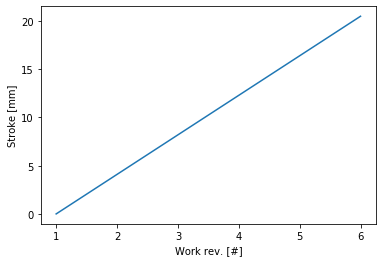

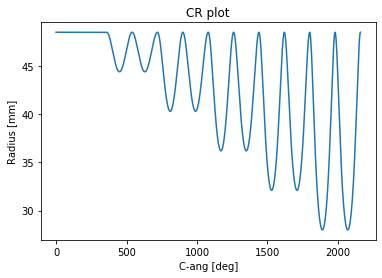

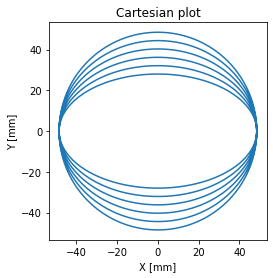

In [4]:
# Generate the CR profile for roughing
doca, a_vector, docb, b_vector, num_revs, l_stroke, CR_vector, X_vector = GenCutProfile(θ, a_initial, a_final, b_initial, b_final, doc, r_wheel)
np.savetxt('CR_5mm_doc.txt',CR_vector, delimiter=',', fmt='%10.6f')   # Save C,R array (work-angle, radius) use exponential notation

print("Depth of cut (max): {:.2f} μm/rev".format(docb*1000))
print("# of work-revs: {:d}".format(num_revs))
plt.plot(range(1,num_revs+1),l_stroke);plt.xlabel('Work rev. [#]');plt.ylabel('Stroke [mm]');
plt.figure();plt.plot(CR_vector[:,0],CR_vector[:,1]);plt.title('CR plot');plt.xlabel('C-ang [deg]');plt.ylabel('Radius [mm]');
XY_vector=Polar2Cart(CR_vector[:,0],CR_vector[:,1])
plt.figure();plt.plot(XY_vector[:,0],XY_vector[:,1]);plt.gca().set_aspect('equal', adjustable='box');plt.title('Cartesian plot');plt.xlabel('X [mm]');plt.ylabel('Y [mm]');

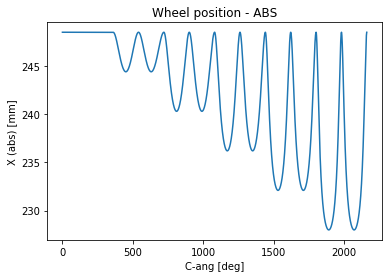

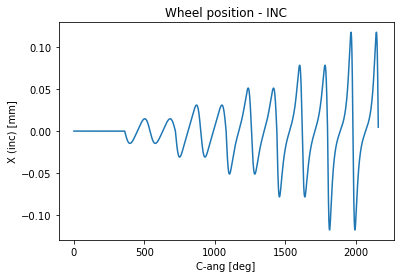

In [5]:
#Generate C_inc, X_inc codes for the machine coordinates
plt.figure();
plt.plot(CR_vector[:,0],X_vector) #[mm] abs X - wheel center position
plt.xlabel('C-ang [deg]')
plt.ylabel('X (abs) [mm]')
plt.title('Wheel position - ABS')

C_inc_vector = np.hstack((0,np.diff(CR_vector[:,0])))
X_inc_vector = np.hstack((0,np.diff(X_vector)))
plt.figure();
plt.plot(CR_vector[:,0],X_inc_vector) #[mm] inc X - wheel center position
plt.xlabel('C-ang [deg]')
plt.ylabel('X (inc) [mm]')
plt.title('Wheel position - INC');

In [6]:
#Save CX-Array - work angle, X-position (incremental)
# np.savetxt('CX_inc_5mm_doc.txt',)
f = open("CX_inc_5mm_doc.txt", "w")
for i in range(len(C_inc_vector)):
    f.write('C{:.6f}\tX{:.6f}\n'.format(C_inc_vector[i],X_inc_vector[i])) #each line, can directly copy into G Code! Make sure to use G21, G91 before running this code
#     f.write('{:10.6f},{:10.6f}\n'.format(C_inc_vector[i],X_inc_vector[i])) #For testing, can plot easily in excel without C, X chars
    
f.close();#Close handle to file once saved

## Wheel-wear vs. cycle time

Nw = work-rpm

S = stock [mm]

d = depth of cut [mm]

r_max = max. component radius [mm]

t = time taken [min]

$MRR' = 2 \pi \cdot N_w \cdot d \cdot r_{max} $ , MRR' should be below a certain limit, can be higher for creep-feed grinding mode to minimize wheel wear

$ t = \frac{S}{d \cdot N_w}$, Time taken for grinding. To minimize time, we need to maximize the product of $d \cdot N_w$ but limiting MRR' limits that!

Therefore, fix MRR' and the maximum work surface speed (fix Nw) we want to run and select the doc based on that to give the MRR'

# Characterisitic features of elliptical profile

In [7]:
a = 48.5 #minor radius
b = 28 #major radius

In [8]:
# r = np.sqrt(1/((np.cos(np.deg2rad(θ))/a)**2+(np.sin(np.deg2rad(θ))/b)**2))
r = GenEllipse(θ,a,b); #[mm] Radial profile of ellipse
ṙ = np.gradient(r,θ,edge_order=2) #velcoity
r̈ = np.gradient(ṙ,θ,edge_order=2) #acceleration
r⃛ = np.gradient(r̈,θ,edge_order=1) #jerk

Max interpolation error: 0.147757 μm


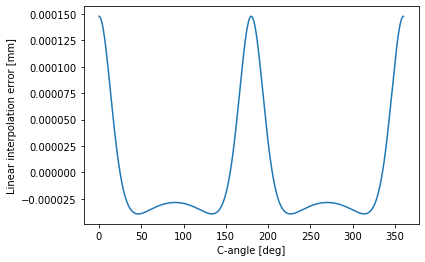

In [9]:
#interpolation error 
#linear as we use G01 command 
#Can be made better if we use G02/G03 command

#Find the mid point acual value between two points and then compare with the avarage radius from the current profile.
θ1 = np.arange(θ_step/2,360,θ_step) #offset and find new theta in between original θ vector
r1 = np.sqrt(1/((np.cos(np.deg2rad(θ1))/a)**2+(np.sin(np.deg2rad(θ1))/b)**2)) #Find the actual value at that location
r_mean_interp = (np.roll(r,-1)+r)/2 #Find average of the radius between two points in the original r-vector
interp_error = r1-r_mean_interp #interpolation error is maximum at the mid-point 

print("Max interpolation error: {:f} μm".format(max(abs(interp_error*1e3))))
plt.plot(θ1,interp_error);plt.xlabel('C-angle [deg]');plt.ylabel('Linear interpolation error [mm]');

In [10]:
x = r*np.cos(np.deg2rad(θ)) #profile x coordinate
y = r*np.sin(np.deg2rad(θ)) #profile y coordinate
xy = np.vstack((x,y)).T ; #xy array
n = np.vstack(((b**2)*x,(a**2)*y)).T ; #Normal vector to each X,Y point based on equation of normal to an ellipse 
                                       # https://www.emathzone.com/tutorials/geometry/equation-of-tangent-and-normal-to-ellipse.html
n̂ = normalized(n) ; #Normalized n vector

In [11]:
Wo = xy + n̂*r_wheel #[mm,mm] Coordinates of the wheel center relative to x,y
X = np.linalg.norm(Wo, ord=2, axis=-1) #Wheel center distance from work ceter distance
X_inc = np.hstack((0,np.diff(X)))
θ_inc = np.hstack((0,np.diff(θ)))
n̂; Wo; X_inc; X
# np.savetxt('test.csv',X_inc)
# Wo.reshape(1800,2).tolist()

array([248.5       , 248.49845752, 248.4938315 , ..., 248.48612614,
       248.4938315 , 248.49845752])

In [12]:
GenWheelOffset(θ,xy,a,b,r_wheel) #To compare with above tool offset

array([248.5       , 248.49845752, 248.4938315 , ..., 248.48612614,
       248.4938315 , 248.49845752])

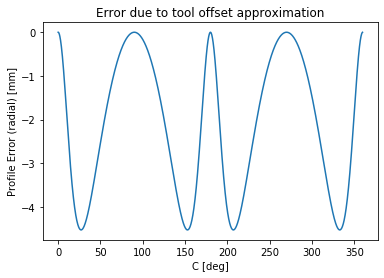

In [13]:
err_appx = X-(r+r_wheel) #[mm] error compared to just adding wheel radius to component radius
plt.plot(θ,err_appx)
plt.title('Error due to tool offset approximation')
plt.xlabel('C [deg]')
plt.ylabel('Profile Error (radial) [mm]');

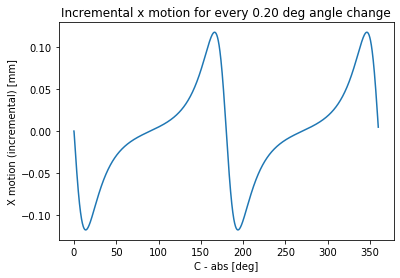

In [14]:
# plt.subplot(2,1,1); 
plt.plot(θ,X_inc)
# plt.subplot(2,1,2)
# plt.plot(θ[1:],θ_inc)
plt.title('Incremental x motion for every {:.2f} deg angle change'.format(θ_step))
plt.xlabel('C - abs [deg]')
plt.ylabel('X motion (incremental) [mm]');

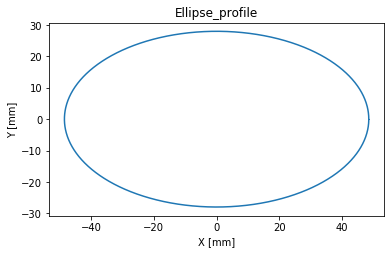

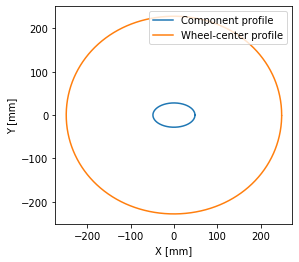

In [15]:
plt.figure()
plt.plot(xy[:,0],xy[:,1],label='Component profile')
plt.title('Ellipse_profile')
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.gca().set_aspect('equal', adjustable='box')

plt.figure()
plt.plot(xy[:,0],xy[:,1],label='Component profile')
plt.plot(Wo[:,0],Wo[:,1], label='Wheel-center profile')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
# plt.title('Ellipse_profile')
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.show()

Smooth acceleration, velocity and jerk profiles


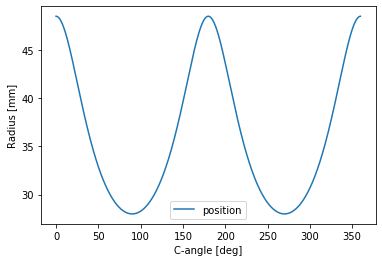

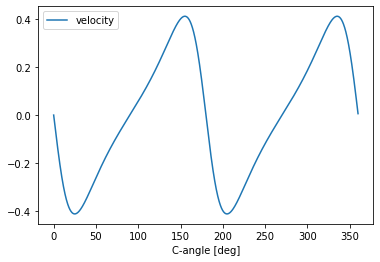

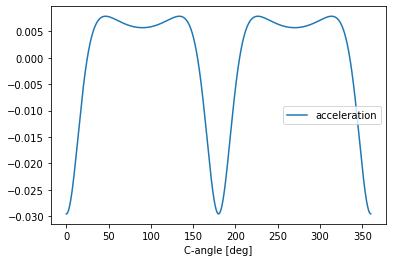

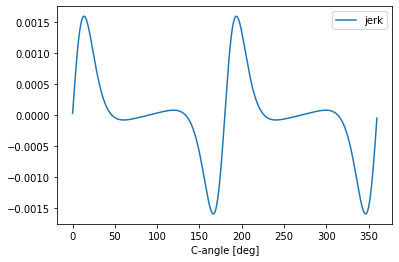

In [16]:
#Plot XVAJ for profile
print("Smooth acceleration, velocity and jerk profiles")
plt.figure()
plt.plot(θ,r,label="position"); plt.legend(); plt.xlabel('C-angle [deg]');plt.ylabel('Radius [mm]')
plt.figure()
plt.plot(θ,ṙ,label="velocity"); plt.legend();plt.xlabel('C-angle [deg]')
plt.figure()
plt.plot(θ,r̈,label="acceleration"); plt.legend();plt.xlabel('C-angle [deg]')
plt.figure()
plt.plot(θ,r⃛,label="jerk"); plt.legend();plt.xlabel('C-angle [deg]');

In [17]:
#Surface velocity
v_surface = ω_work*r*60 #[mm/min]

#depth of cut
doca, a_vector, docb, b_vector, num_revs, l_stroke, CR_vector, X_vector = GenCutProfile(θ, a, a, b+3*doc, b, doc, r_wheel)
docAng = CR_vector[2*len(θ):(3)*len(θ),1] - CR_vector[3*len(θ):(4)*len(θ),1] #[mm] radial depth of cut 
print(doca,num_revs)

#MRR'
Q_prime = docAng*v_surface #[mm^2/min]

nan 4


C:\Users\Brij\Miniconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


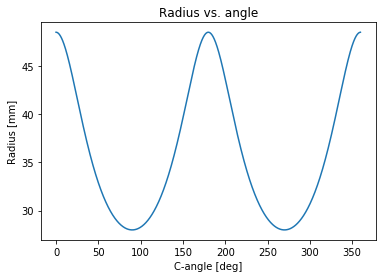

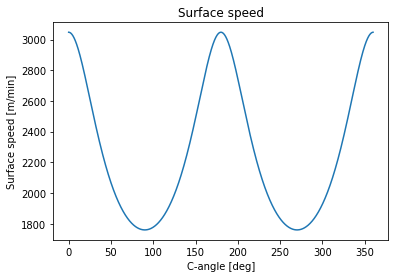

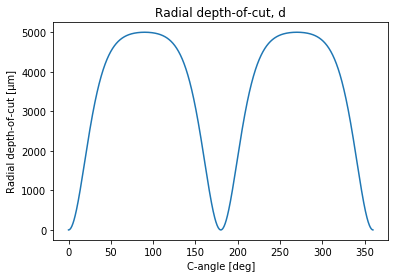

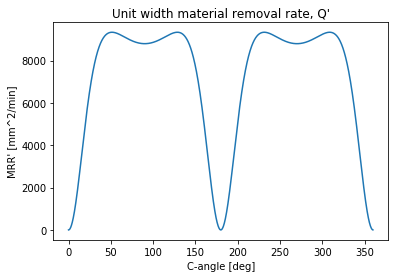

In [18]:
plt.figure()
plt.plot(θ,r); plt.xlabel('C-angle [deg]');plt.ylabel('Radius [mm]');plt.title('Radius vs. angle')
plt.figure()
plt.plot(θ,v_surface);plt.xlabel('C-angle [deg]');plt.ylabel('Surface speed [m/min]'); plt.title('Surface speed');
plt.figure()
plt.plot(θ,docAng*1e3);plt.xlabel('C-angle [deg]');plt.ylabel('Radial depth-of-cut [μm]'); plt.title('Radial depth-of-cut, d');
plt.figure()
plt.plot(θ,Q_prime);plt.xlabel('C-angle [deg]');plt.ylabel('MRR\' [mm^2/min]'); plt.title('Unit width material removal rate, Q\'');

# Sandbox Code, not used

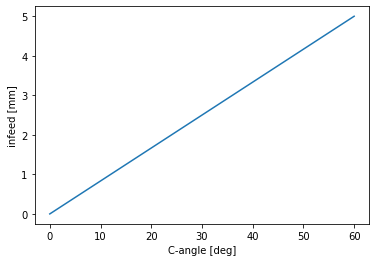

In [19]:
# For ramping the depth of cut
ramp_start = 50 #[deg] Ramp start angle
ramp_angle = 60 #[deg] Ramp angle
ramp_vector = θ[θ<=ramp_angle]/ramp_angle*doc #ramp vector to give feed gradually
plt.plot(θ[θ<=ramp_angle],ramp_vector); plt.xlabel('C-angle [deg]');plt.ylabel('infeed [mm]');

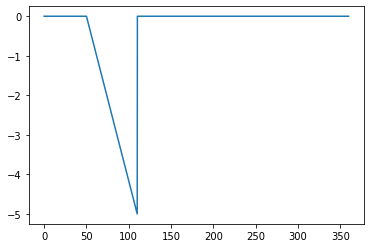

In [20]:
γ = RampVec(θ,ramp_start,ramp_angle,doc)
plt.plot(θ,γ)